In [1]:
#install kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle (3).json': b'{"username":"saumyadadu22bce10566","key":"05e95ef5e62687c02da4c5551aafbbc8"}'}

In [3]:
#creating a kaggle folder
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [85]:
!kaggle datasets list

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                          Student Performance Factors                          94KB  2024-09-02 10:53:57           8894        193  1.0              
prokshitha/home-value-insights                                   House Price Regression Dataset                       26KB  2024-09-06 15:15:12           1105         33  1.0              
hanaksoy/customer-purchasing-behaviors                           Customer Purchasing Behaviors                         1KB  2024-09-01 22:18:07           4583         64  1.0              
hanaksoy/health-and-sleep-statistics                   

In [6]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

plant-pathology-2021-fgvc8.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip plant-pathology-2021-fgvc8.zip[n]

unzip:  cannot find or open plant-pathology-2021-fgvc8.zip[n], plant-pathology-2021-fgvc8.zip[n].zip or plant-pathology-2021-fgvc8.zip[n].ZIP.

No zipfiles found.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import files

# Constants
HEIGHT, WIDTH = 224, 224  # EfficientNetB0 default input size
BATCH_SIZE = 32
EPOCHS = 6
SEED = 42
STEPS_PER_EPOCH = 5  # Reduced steps per epoch
VALIDATION_STEPS = 10  # Reduced validation steps

# Load and preprocess data
train_image_path = '/content/train_images'
test_image_path = '/content/test_images'
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/sample_submission.csv')

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    vertical_flip=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_image_path,
    x_col="image",
    y_col="labels",
    target_size=(HEIGHT, WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset="training",
    shuffle=True,
    seed=SEED
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_image_path,
    x_col="image",
    y_col="labels",
    target_size=(HEIGHT, WIDTH),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=True,
    seed=SEED
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_image_path,
    x_col='image',
    y_col=None,
    target_size=(HEIGHT, WIDTH),
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Build the model
efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

model = Sequential([
    Lambda(lambda x: hub.KerasLayer(efficientnet_url, trainable=False)(x), input_shape=(HEIGHT, WIDTH, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display model summary
model.summary()

# Callbacks
# Callbacks
checkpoint_path = "best_model.keras" # Changed the file extension to .keras
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model with reduced steps
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(validation_generator, steps=VALIDATION_STEPS)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

# Make predictions on test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Create submission file
submission_df = pd.DataFrame({
    'image': test_df['image'],
    'labels': [list(train_generator.class_indices.keys())[i] for i in predicted_classes]
})
submission_df.to_csv('submission.csv', index=False)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Function to upload and classify a single image
def upload_and_classify_image():
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Read and preprocess the image
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (HEIGHT, WIDTH))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        # Make prediction
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction, axis=1)[0]
        class_name = list(train_generator.class_indices.keys())[predicted_class]
        confidence = prediction[0][predicted_class]

        # Display results
        plt.imshow(img[0])
        plt.title(f"Predicted: {class_name}\nConfidence: {confidence:.2f}")
        plt.axis('off')
        plt.show()

        print(f"Predicted class: {class_name}")
        print(f"Confidence: {confidence:.2f}")

# Call the function to upload and classify an image
upload_and_classify_image()

Found 14906 validated image filenames belonging to 12 classes.
Found 3726 validated image filenames belonging to 12 classes.
Found 3 validated image filenames.


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_9 (Lambda)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,516 (646.55 KB)

 Trainable params: 165,516 (646.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2569 - loss: 2.0903 - precision_9: 0.4045 - recall_9: 0.0460
Epoch 1: val_accuracy improved from -inf to 0.51562, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 213s 4s/step - accuracy: 0.2588 - loss: 2.0856 - precision_9: 0.4075 - recall_9: 0.0469 - val_accuracy: 0.5156 - val_loss: 1.4655 - val_precision_9: 0.8523 - val_recall_9: 0.2344
Epoch 2/25
 8/50 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.4656 - loss: 1.5906 - precision_9: 0.5762 - recall_9: 0.1758

In [88]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import random
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [89]:
train_image_path = '/content/train_images'
test_image_path = '/content/test_images'
train_df_path = '/content/train.csv'
test_df_path = '/content/sample_submission.csv'

In [90]:
df_train = pd.read_csv(train_df_path)
df_test=pd.read_csv(test_df_path)

In [91]:
df_test

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [92]:
df_train.labels.value_counts()

,count
labels,
scab,4826
healthy,4624
frog_eye_leaf_spot,3181
rust,1860
complex,1602
powdery_mildew,1184
scab frog_eye_leaf_spot,686
scab frog_eye_leaf_spot complex,200
frog_eye_leaf_spot complex,165


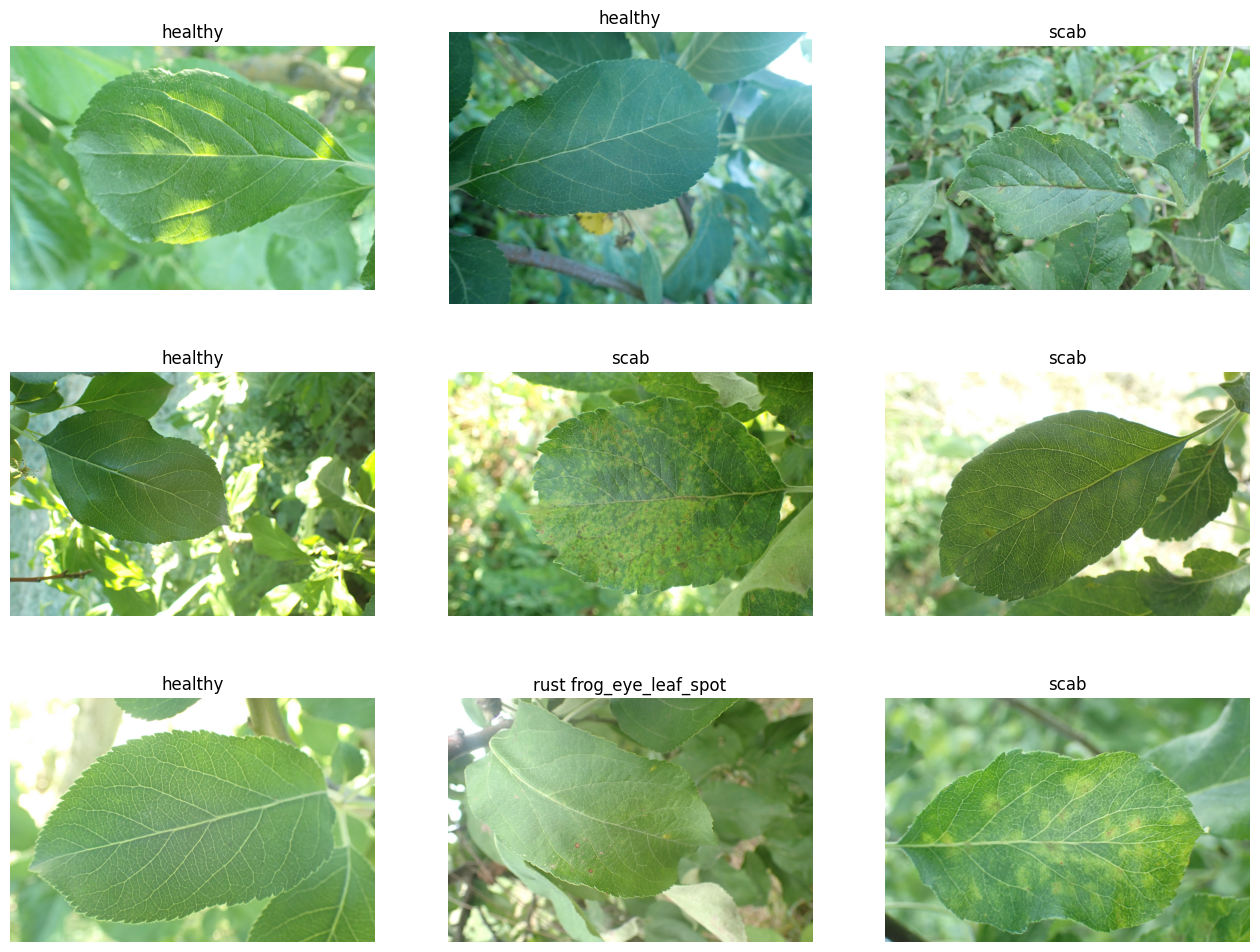

In [93]:
def batch_visualize(df,batch_size,path):
    sample_df = df_train.sample(9)
    image_names = sample_df["image"].values
    labels = sample_df["labels"].values
    plt.figure(figsize=(16, 12))

    for image_ind, (image_name, label) in enumerate(zip(image_names, labels)):
        plt.subplot(3, 3, image_ind + 1)
        image = cv2.imread(os.path.join(path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    plt.show()

batch_visualize(df_train,9,train_image_path)

In [94]:
HEIGHT = 128
WIDTH=128
SEED = 45
BATCH_SIZE= 64

train_datagen = ImageDataGenerator(rescale = 1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    vertical_flip = False)

train_dataset = train_datagen.flow_from_dataframe(
    df_train,
    directory = train_image_path,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "training",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

validation_dataset = train_datagen.flow_from_dataframe(
    df_train,
    directory = train_image_path,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "validation",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)
INPUT_SIZE = (HEIGHT,WIDTH,3)
test_dataset=test_datagen.flow_from_dataframe(
    df_test,
    directory=test_image_path,
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=INPUT_SIZE[:2]
)


Found 14906 non-validated image filenames belonging to 12 classes.
Found 3726 non-validated image filenames belonging to 12 classes.
Found 3 validated image filenames.


In [95]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(HEIGHT,WIDTH,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(12,activation='softmax'))

In [96]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 12)                  │          98,316 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 228,492 (892.55 KB)

 Trainable params: 228,492 (892.55 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
checkpoint_path = "training_1/cp.ckpt.weights.h5" # Added '.weights.h5' to the file path to comply with Keras requirement when saving weights only.
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [98]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Wrap the KerasLayer in a Lambda layer
efficientnet_model = Sequential([
    tf.keras.layers.Lambda(lambda x: hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)(x))
])

combined_model = Sequential([
    efficientnet_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

precision = tf.keras.metrics.Precision()

combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', precision])

combined_model_history = combined_model.fit(train_dataset, # Changed 'fit_generator' to 'fit'
                                                      validation_data=validation_dataset,
                                                      epochs=25,
                                                      steps_per_epoch=12 // BATCH_SIZE,
                                                      validation_steps=validation_dataset.samples // BATCH_SIZE,
                                                      callbacks=[cp_callback])

Epoch 1/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3841 - loss: 1.7737 - precision_4: 0.5852
Epoch 1: saving model to training_1/cp.ckpt.weights.h5
233/233 ━━━━━━━━━━━━━━━━━━━━ 988s 4s/step - accuracy: 0.3844 - loss: 1.7729 - precision_4: 0.5856 - val_accuracy: 0.5757 - val_loss: 1.2673 - val_precision_4: 0.7690
Epoch 2/25
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5380 - loss: 1.3803 - precision_4: 0.7101
Epoch 2: saving model to training_1/cp.ckpt.weights.h5
233/233 ━━━━━━━━━━━━━━━━━━━━ 774s 3s/step - accuracy: 0.5380 - loss: 1.3803 - precision_4: 0.7101 - val_accuracy: 0.3571 - val_loss: 1.6122 - val_precision_4: 0.5714
Epoch 3/25
145/233 ━━━━━━━━━━━━━━━━━━━━ 4:47 3s/step - accuracy: 0.5544 - loss: 1.3357 - precision_4: 0.7182

KeyboardInterrupt: 

In [ ]:
train_dataset.class_indices.items()

In [ ]:
preds = model.predict(test_dataset)
print(preds)

In [ ]:
preds_disease_ind=np.argmax(preds, axis=-1)

In [ ]:
preds_disease_ind